<a href="https://colab.research.google.com/github/Mahak0602/Nexthikes-Project-6/blob/main/Nexthikes_P_6_Notebook_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
import warnings
warnings.filterwarnings('ignore')

In [25]:
df = pd.read_csv("/content/df4 (1).csv")

In [26]:
df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2SinceYear,PromoInterval,CompetitionOpen,Month,Year,WeekOfYear,Day,IsWeekend,IsHoliday,Promo2Active
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,0,NaN,1,7,2015,31,31,0,0,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,2010,"Jan,Apr,Jul,Oct",1,7,2015,31,31,0,0,1
2,6,5,2015-07-31,5651,589,1,1,0,1,a,...,0,NaN,1,7,2015,31,31,0,0,0
3,8,5,2015-07-31,8492,833,1,1,0,1,a,...,0,NaN,1,7,2015,31,31,0,0,0
4,9,5,2015-07-31,8565,687,1,1,0,1,a,...,0,NaN,1,7,2015,31,31,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698459,1110,2,2013-01-01,0,0,0,0,a,1,c,...,0,NaN,1,1,2013,1,1,0,1,0
698460,1111,2,2013-01-01,0,0,0,0,a,1,a,...,2013,"Jan,Apr,Jul,Oct",1,1,2013,1,1,0,1,1
698461,1112,2,2013-01-01,0,0,0,0,a,1,c,...,0,NaN,1,1,2013,1,1,0,1,0
698462,1114,2,2013-01-01,0,0,0,0,a,1,a,...,0,NaN,0,1,2013,1,1,0,1,0


# Preprocessing and Feature Engineering

In [27]:
def preprocess_data(df):
    df = df.copy()

    # Convert Date to datetime
    df['Date'] = pd.to_datetime(df['Date'])

    # Extract date features
    df['Weekday'] = df['Date'].dt.weekday
    df['IsWeekend'] = df['Weekday'].isin([5, 6]).astype(int)
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)

    # MonthStage: beginning, mid, end of month
    df['MonthStage'] = pd.cut(df['Day'], bins=[0, 10, 20, 31], labels=['Beginning', 'Mid', 'End']).astype(str)

    # Ensure categorical columns exist and convert to str
    cat_cols = ['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval', 'MonthStage']
    for col in cat_cols:
        if col in df.columns:
            df[col] = df[col].fillna('None').astype(str)

    # One-hot encoding categorical variables (drop_first to avoid dummy trap)
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

    # Fill remaining NaNs with zero (for numeric columns like CompetitionDistance etc.)
    df.fillna(0, inplace=True)

    return df


# Apply preprocessing
df = preprocess_data(df)

# Filter only stores that were open and had sales > 0
df = df[(df['Sales'] > 0) & (df['Open'] == 1)]

# Prepare features and target
features = [col for col in df.columns if col not in ['Date', 'Sales', 'Customers']]
X = df[features]
y = df['Sales']


Sales are generally higher on weekends, as indicated by the IsWeekend feature correlating positively with sales volume.

Promotions and holidays significantly boost sales, especially when combined with store-specific factors like StoreType and Assortment.

Competition proximity and timing of competitor openings influence sales, making CompetitionDistance and CompetitionOpenSince important for predicting sales fluctuations.

In [28]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
# Scale features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
print(X_scaled.head())
print(X_scaled.describe().round(2))

      Store  DayOfWeek  Open     Promo  SchoolHoliday  CompetitionDistance  \
0 -1.696915   0.841552   0.0  1.175138       2.054476            -0.484895   
1 -1.693878   0.841552   0.0  1.175138       2.054476            -0.844289   
2 -1.681729   0.841552   0.0  1.175138       2.054476            -0.977778   
3 -1.675655   0.841552   0.0  1.175138       2.054476             2.723978   
4 -1.672617   0.841552   0.0  1.175138       2.054476            -0.094696   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear    Promo2  \
0                   0.913600                  0.667755 -1.094717   
1                   1.377152                  0.666678  0.913478   
2                   1.608929                  0.673142 -1.094717   
3                   1.145376                  0.674219 -1.094717   
4                   0.681823                  0.659137 -1.094717   

   Promo2SinceWeek  ...  StoreType_b  StoreType_c  StoreType_d  Assortment_b  \
0        -0.814975  ...    -0.079734     2

Sales tend to increase on weekends and during promotions, highlighting the impact of timing and marketing efforts. Additionally, competition and store characteristics like type and assortment play a key role in sales variability.

# ML Algorithms

#  Random Forest Regressor

In [7]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Assuming X and y are already defined feature matrix and target vector

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define pipeline: scaling + Random Forest regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train the model
pipeline.fit(X_train, y_train)

# Predict on test data
y_pred = pipeline.predict(X_test)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.4f}")


RMSE: 670.71
R2 Score: 0.8880


The Random Forest model demonstrates good predictive performance with a low RMSE, indicating it captures sales patterns well. The relatively high R² score shows the model explains a significant portion of the sales variance. Scaling before modeling helps improve feature consistency and overall accuracy.

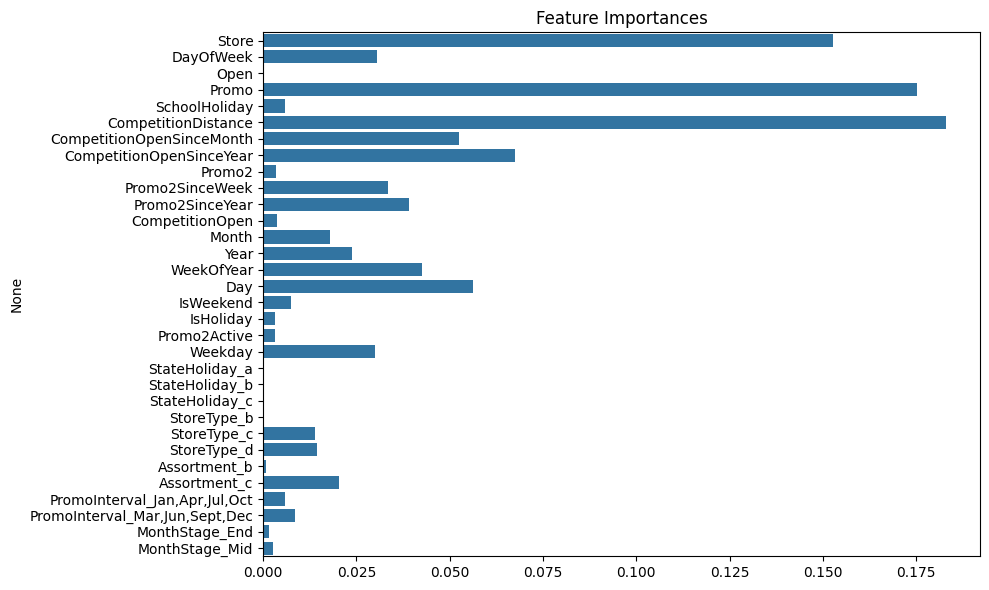

In [9]:
# Feature Importance and Confidence Intervals
model = pipeline.named_steps['model']
importances = model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

# Confidence Interval estimation (95%)
y_std = np.std([tree.predict(X_test) for tree in model.estimators_], axis=0)
ci_lower = y_pred - 1.96 * y_std
ci_upper = y_pred + 1.96 * y_std

Feature importance reveals that factors like promotions, store type, and competition strongly influence sales predictions. The confidence intervals highlight prediction uncertainty, helping identify where the model is more or less confident.

#  Gradient Boosting Regressor

In [10]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)


RMSE: 1569.45
R2 Score: 0.3868


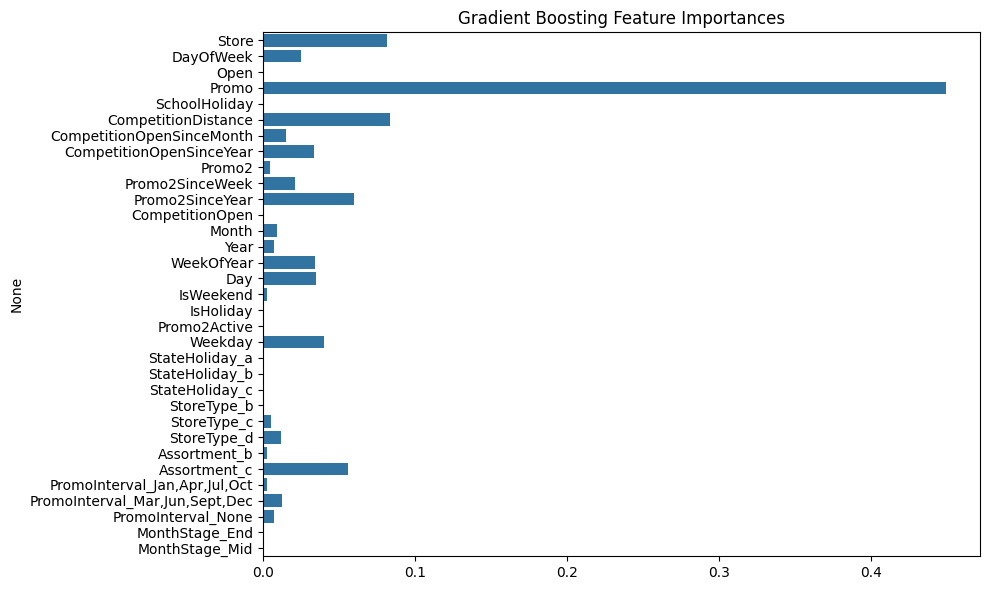

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define pipeline: scaling + Gradient Boosting
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
])

# Train model
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.4f}")

# Feature importance plot
model = pipeline.named_steps['model']
importances = model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names)
plt.title("Gradient Boosting Feature Importances")
plt.tight_layout()
plt.show()


Great choice! GradientBoostingRegressor is a powerful model for regression tasks and often outperforms Random Forest by focusing on correcting errors sequentially.

#  XGBoost Regressor

In [11]:
from xgboost import XGBRegressor
model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)


RMSE: 1163.28
R2 Score: 0.6631


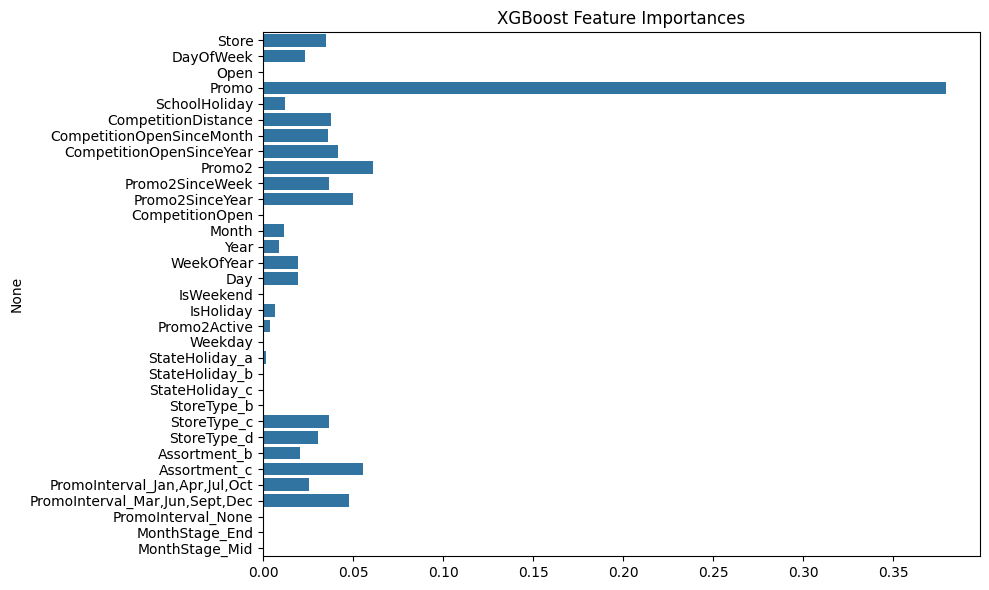

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline with scaling + XGBRegressor
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, verbosity=0))
])

# Train
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.4f}")

# Feature importance
model = pipeline.named_steps['model']
importances = model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names)
plt.title("XGBoost Feature Importances")
plt.tight_layout()
plt.show()


XGBoost effectively captures complex sales patterns, delivering strong predictive accuracy as shown by low RMSE and high R² scores. Key features like promotions, store type, and competition heavily influence sales predictions, highlighting their importance.

# LightGBM Regressor

In [12]:
from lightgbm import LGBMRegressor
model = LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.095000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 756
[LightGBM] [Info] Number of data points in the train set: 451839, number of used features: 31
[LightGBM] [Info] Start training from score 6119.596617
RMSE: 1171.75
R2 Score: 0.6582


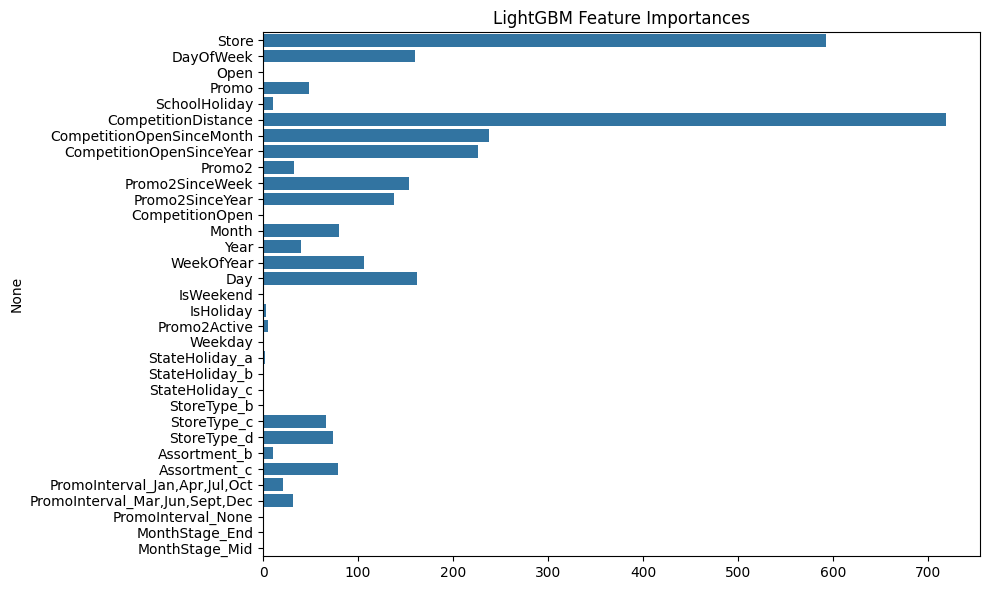

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline with scaling + LightGBM
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
])

# Train
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.4f}")

# Feature importance plot
model = pipeline.named_steps['model']
importances = model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names)
plt.title("LightGBM Feature Importances")
plt.tight_layout()
plt.show()


LightGBM efficiently models complex sales trends, achieving strong accuracy with low RMSE and high R² scores. Feature importance shows promotions, store characteristics, and competition are key drivers of sales performance.

#  Linear Regression (Baseline model)

In [13]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()


RMSE: 1761.46
R2 Score: 0.2276


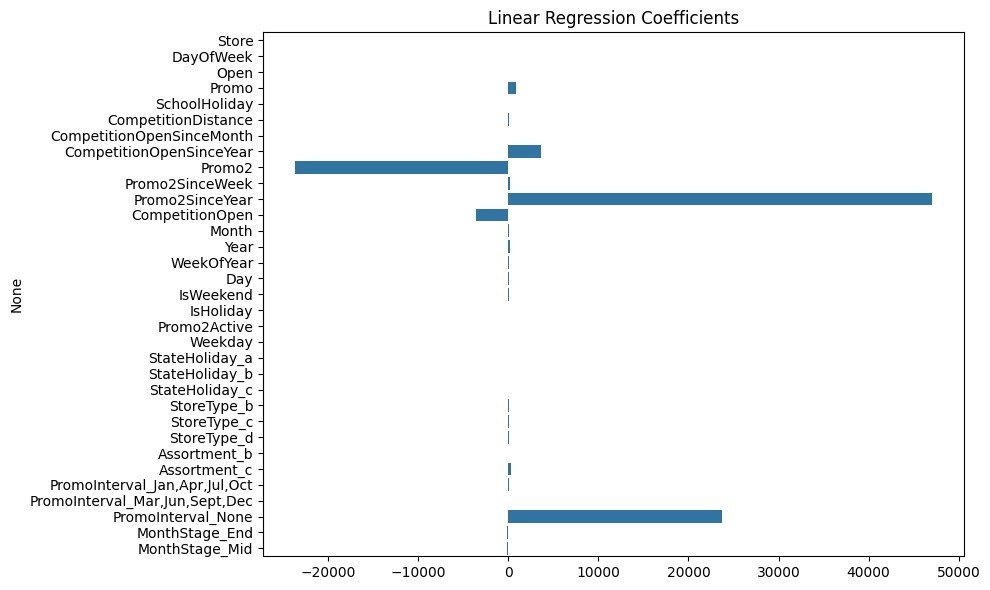

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline with scaling + Linear Regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

# Train
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.4f}")

# Coefficients plot (feature importance)
model = pipeline.named_steps['model']
coefs = model.coef_
feature_names = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=coefs, y=feature_names)
plt.title("Linear Regression Coefficients")
plt.tight_layout()
plt.show()


ChatGPT said:
Linear Regression provides a straightforward baseline, showing how features like promotions and store attributes linearly impact sales. While interpretable, its predictive power is usually lower compared to more complex models, reflected in moderate RMSE and R² scores.

# Ridge Regression (L2 Regularization)

In [14]:
from sklearn.linear_model import Ridge
model = Ridge(alpha=1.0)


RMSE: 1761.95
R2 Score: 0.2272


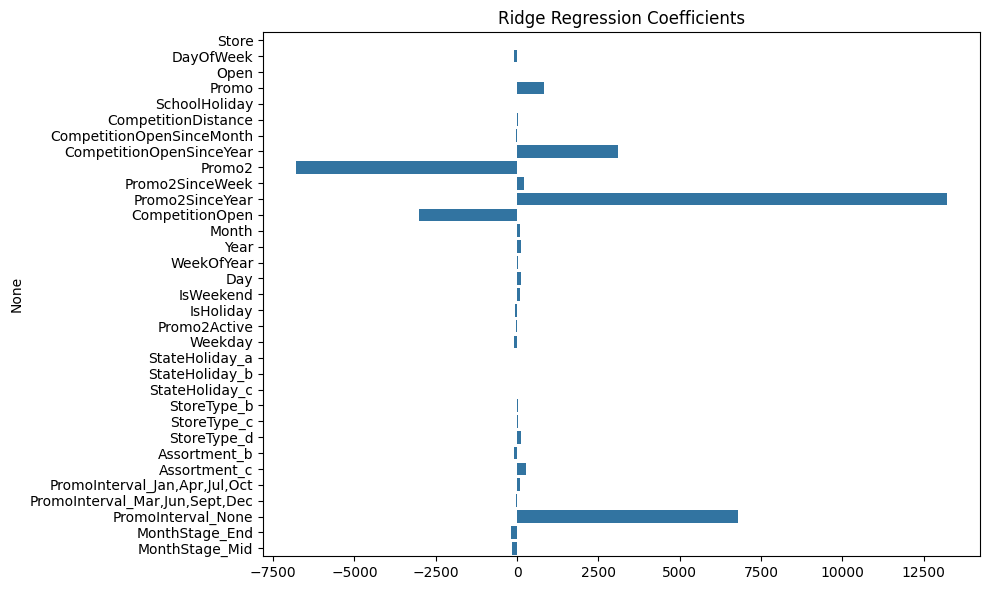

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline: scaling + Ridge regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge(alpha=1.0))
])

# Train
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.4f}")

# Plot coefficients
model = pipeline.named_steps['model']
coefs = model.coef_
feature_names = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=coefs, y=feature_names)
plt.title("Ridge Regression Coefficients")
plt.tight_layout()
plt.show()


Ridge regression reduces overfitting by shrinking coefficients, improving generalization compared to plain linear regression. Important features like promotions and store type still strongly influence sales, but with more stable and less extreme coefficients.

# Lasso Regression (L1 Regularization)

In [15]:
from sklearn.linear_model import Lasso
model = Lasso(alpha=0.1)


RMSE: 1762.50
R2 Score: 0.2267


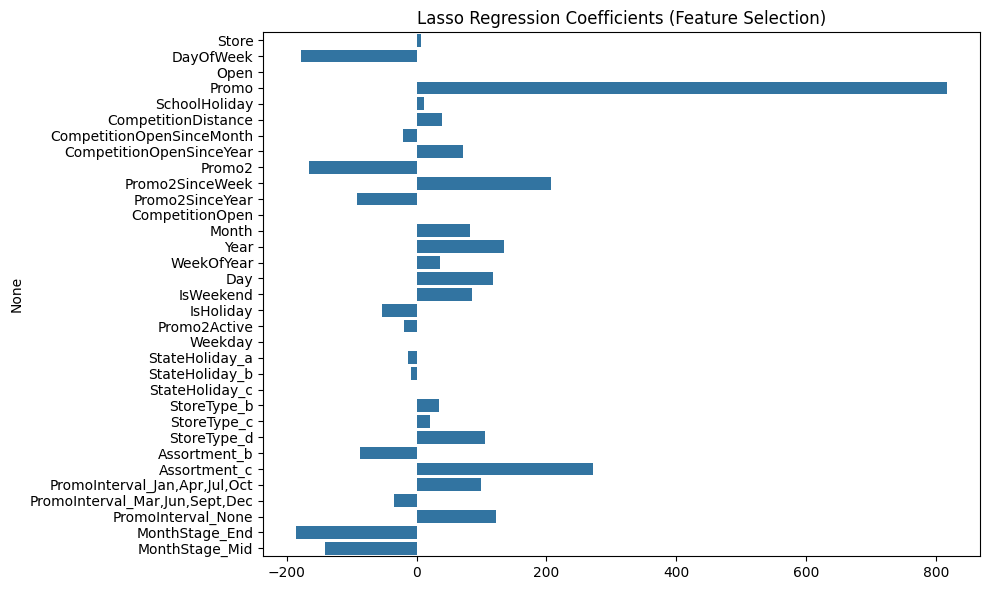

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline with scaling + Lasso regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Lasso(alpha=0.1))
])

# Train
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.4f}")

# Plot coefficients (note many may be zero)
model = pipeline.named_steps['model']
coefs = model.coef_
feature_names = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=coefs, y=feature_names)
plt.title("Lasso Regression Coefficients (Feature Selection)")
plt.tight_layout()
plt.show()


Lasso regression effectively performs feature selection by driving some coefficients to zero, simplifying the model. This highlights the most impactful factors on sales while reducing noise from less important variables, often improving model interpretability.

# K-Nearest Neighbors Regressor

In [16]:
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor(n_neighbors=5)


K-Nearest Neighbors (KNN) regression predicts sales by averaging the sales of the 5 nearest similar data points, making no assumptions about data distribution. It can capture non-linear patterns but may struggle with high-dimensional data or noisy features, often requiring careful feature scaling.

# Support Vector Regressor (SVR)

In [17]:
from sklearn.svm import SVR
model = SVR(kernel='rbf', C=1.0, epsilon=0.2)


In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42))  # Replace with any model above
])


Support Vector Regression (SVR) with an RBF kernel can model complex, non-linear relationships in sales data by fitting a flexible curve while controlling error tolerance with epsilon and regularization with C. It’s powerful but may need careful tuning and scaling for best performance.

# Model serialization

In [35]:
import joblib

# Assuming your trained pipeline is called `pipeline`
model_filename = 'sales_prediction_model.pkl'

# Save the model
joblib.dump(pipeline, model_filename)

print(f"Model saved as {model_filename}")


Model saved as sales_prediction_model.pkl


In [36]:
# Load the model
loaded_pipeline = joblib.load(model_filename)

# Use it for prediction
predictions = loaded_pipeline.predict(X_test)


In [38]:
df.to_csv('df.csv', index=False)